### RandomForrest Model with SCFP for the target SR-p35

In [2]:
import deepchem as dc
import numpy as np
from rdkit import Chem
import pandas as pd
import seaborn as sns
from rdkit.Chem.rdmolfiles import MolToSmiles
from tqdm.auto import tqdm
import sys
import cupy as cp
from chainer import serializers
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
  
sys.path.append('../')
from SCFP_functions.feature import *
import SCFP_functions.SCFPfunctions as Mf
import SCFP_functions.SCFPmodel as Mm
from SCFP_functions.constants import lensize
from SCFP_functions.constants import scfp_model_args as args

In [4]:
#-------------------------------
# GPU check
xp = np
if args["gpu"] >= 0:
    print('GPU mode')
    xp = cp

GPU mode


### Model: Training

In [5]:
file='../data/tox21_SR-p53/tox21_data_all.smiles'
print('Loading smiles: ', file)
smi = Chem.SmilesMolSupplier(file,delimiter='\t',titleLine=False)
mols = [mol for mol in smi if mol is not None]
smiles = [MolToSmiles(smiles) for smiles in mols]

F_list, T_list = [],[]
for mol in mols:
    if len(Chem.MolToSmiles(mol, kekuleSmiles=True, isomericSmiles=True)) > args["atomsize"]: print("SMILES is too long. This mol will be ignored.")
    else:
        F_list.append(mol_to_feature(mol,-1,args["atomsize"]))
        T_list.append(mol.GetProp('_Name') )            
Mf.random_list(F_list)
Mf.random_list(T_list)
data_t = np.asarray(T_list, dtype=np.int32).reshape(-1,1)
data_f = np.asarray(F_list, dtype=np.float32).reshape(-1,1,args["atomsize"],lensize)
print(data_t.shape, data_f.shape)

Loading smiles:  ../data/tox21_SR-p53/tox21_data_all.smiles


[17:49:36] WARNING: not removing hydrogen atom without neighbors
[17:49:42] WARNING: not removing hydrogen atom without neighbors


(8056, 1) (8056, 1, 400, 42)


In [6]:
vectorizer_model = Mm.CNN(args["atomsize"], lensize, args["k1"], args["s1"], args["f1"], args["k2"], args["s2"], args["k3"], args["s3"], args["f3"],args["k4"], args["s4"],args["n_hid"],args["n_out"])

In [7]:
def vectorize():
    data_x = []
    data_y = []

    with cp.cuda.Device(args["gpu"]):
        serializers.load_npz('../model_output/model_snapshot_500', vectorizer_model)

    for index, x in enumerate(data_f):
        # x
        scfp = vectorizer_model.fingerprint(x).flatten()
        data_x.append(np.array(scfp))
        # y
        y = data_t[index].flatten()
        data_y.append(np.array(y))
    return  dc.data.NumpyDataset(X=data_x, y=data_y, ids=smiles)

dataset = vectorize()

In [8]:
splitter = dc.splits.RandomStratifiedSplitter()
metrics_arr = [dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean)]

In [9]:
def model_builder(model_dir):
  class_weights = class_weight.compute_class_weight("balanced", classes=np.unique(dataset.y.flatten()), y=dataset.y.flatten())

  sklearn_model = RandomForestClassifier(class_weight={0: class_weights[0], 1: class_weights[1]})
  return dc.models.SklearnModel(sklearn_model, model_dir)

100%|██████████| 5/5 [00:10<00:00,  2.11s/it]

[0.9999446079633718, 0.9999170141443872, 0.9998761344125583, 0.9998851279535605, 0.9999611642547626]
[0.9098948188546941, 0.8931047915855084, 0.9012985326580963, 0.913868328788469, 0.9367874302038697]


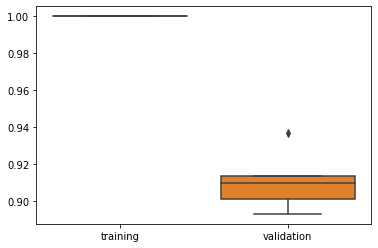

In [10]:
training_score_list = []
validation_score_list = []
transformers = []
cv_folds = 5
for i in tqdm(range(0,cv_folds)):
    model = model_builder('./model_dir')
    train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset)
    model.fit(train_dataset)
    train_scores = model.evaluate(train_dataset, metrics_arr, transformers)
    training_score_list.append(train_scores["mean-roc_auc_score"])
    validation_scores = model.evaluate(valid_dataset, metrics_arr, transformers)
    validation_score_list.append(validation_scores["mean-roc_auc_score"])
print(training_score_list)
print(validation_score_list)

sns.boxplot(x=["training"]*cv_folds+["validation"]*cv_folds,y=training_score_list+validation_score_list);

In [11]:
model = model_builder('./model_dir')
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset, seed=42)
model.fit(train_dataset)

### Model: Testing

false_negative: 45
true_positive: 6
false_positive: 0
true_negative: 754
recall: 0.11764705882352941
precision 0.9440993788819876
f1: 0.9440993788819876
roc-auc: 0.5588235294117647


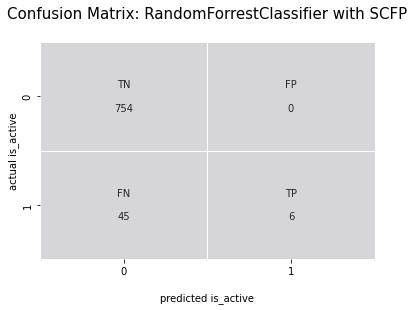

In [14]:
pred = [x.flatten() for x in model.predict(test_dataset)]
pred = [int((prediction[0] < prediction[1]) == True) for prediction in pred]
pred_df = pd.DataFrame(pred,columns=["prediction"])
pred_df["active"] = [int(x) for x in test_dataset.y]
pred_df["SMILES"] = test_dataset.ids

false_negative_df = pred_df.query("active == 1 & prediction == 0").copy()
true_positive_df = pred_df.query("active == 1 & prediction == 1").copy()
false_positive_df = pred_df.query("active == 0 & prediction == 1").copy()
true_negative_df = pred_df.query("active == 0 & prediction == 0").copy()
print("false_negative:", false_negative_df.shape[0])
print("true_positive:", true_positive_df.shape[0])
print("false_positive:", false_positive_df.shape[0])
print("true_negative:", true_negative_df.shape[0])

recall = recall_score(test_dataset.y.flatten(), pred)
precision = precision_score(test_dataset.y.flatten(), pred, average='micro')
f1 = f1_score(test_dataset.y.flatten(), pred, average='micro')
auc = roc_auc_score(test_dataset.y.flatten(), pred, average='micro')
print("recall:", recall)
print("precision", precision)
print("f1:", f1)
print("roc-auc:", auc)

cf_matrix = confusion_matrix(test_dataset.y.flatten(), pred)
group_names = ['TN','FP','FN','TP']

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]

labels = [f"{v1}\n\n{v2}" for v1, v2 in zip(group_names,group_counts)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, linecolor="white", linewidths=.5, fmt='', cmap=["#d6d6d9"], cbar=False)

ax.set_title('Confusion Matrix: RandomForrestClassifier with SCFP\n',fontsize=15);
ax.set_xlabel('\npredicted is_active')
ax.set_ylabel('actual is_active');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])

## Display the visualization of the Confusion Matrix.
plt.show()
savefigure = ax.get_figure()
savefigure.savefig('../results/confusion_matrix_rf_tox21.png', format='png', dpi=1000, bbox_inches='tight')